In [1]:
from CherryTreeDataset import CherryTreeDataset
from torchvision import transforms
from funciones_auxiliares import plot_spectra, analyze_image, analyze_tiff_metadata, PATH, crop_central_region
from resnet_adapters import adapt_resnet_channels
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, SqueezeNet1_1_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn


In [2]:
# Define las transformaciones si son necesarias
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Lambda(lambda x: crop_central_region(x, center_ratio=0.8)),
    transforms.ToTensor()
])

#formats = ( 'RGB.JPG','RED.TIF','GRE.TIF','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG','NIR.TIF','REG.TIF')
formats = ('RGB.JPG',)
dataset = CherryTreeDataset(PATH, transform=transform, formats = formats, concatenate = True, healthy_ratio=3)

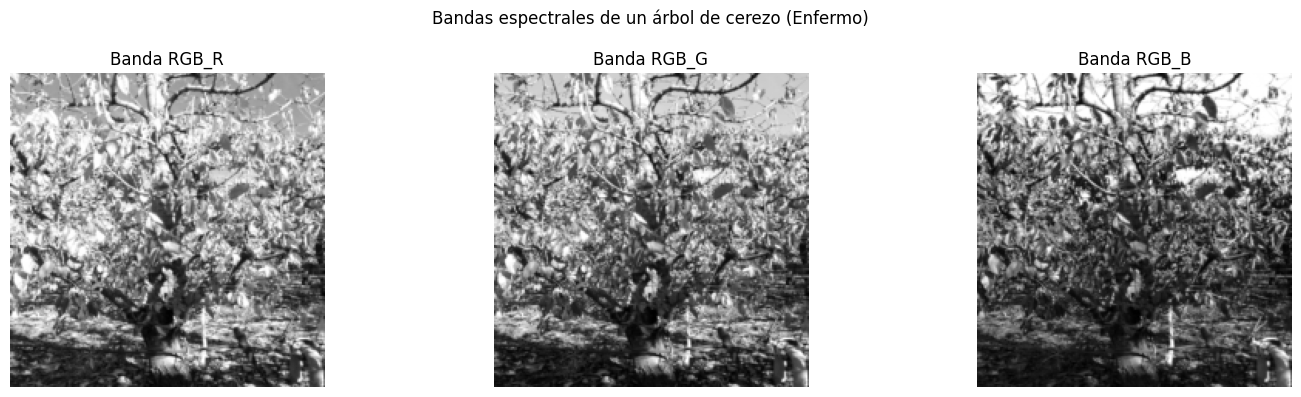

Number of samples for Healthy: 618
Number of samples for Disease: 206


In [3]:
images, label = dataset[20]  
plot_spectra(images, label)
dataset.print_class_counts()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'El dispositivo seleccionado es {device}')

El dispositivo seleccionado es cuda


In [5]:
# Separa los índices por clase
healthy_indices = []
disease_indices = []

for i, (_, label) in enumerate(dataset.samples):
    if label == 0:  # Healthy
        healthy_indices.append(i)
    else:  # Disease
        disease_indices.append(i)
# Mezcla los índices
np.random.shuffle(healthy_indices)
np.random.shuffle(disease_indices)

# Divide en entrenamiento y prueba (80% - 20%)
train_healthy = healthy_indices[:int(0.8 * len(healthy_indices))]
test_healthy = healthy_indices[int(0.8 * len(healthy_indices)):]

train_disease = disease_indices[:int(0.8 * len(disease_indices))]
test_disease = disease_indices[int(0.8 * len(disease_indices)):]

# Combina los índices
train_indices = np.concatenate([train_healthy, train_disease])
test_indices = np.concatenate([test_healthy, test_disease])

# Mezcla los índices combinados
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Crea los subconjuntos
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Crea los dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=20)

In [6]:
train_healthy_ratio = len(train_healthy) / len(train_indices)
test_healthy_ratio = len(test_healthy) / len(test_indices)
print(f"Ratio de muestras saludables en entrenamiento: {train_healthy_ratio:.4f}")
print(f"Ratio de muestras saludables en prueba: {test_healthy_ratio:.4f}")

Ratio de muestras saludables en entrenamiento: 0.7508
Ratio de muestras saludables en prueba: 0.7470


In [7]:
#resnet = models.squeezenet1_1(SqueezeNet1_1_Weights.IMAGENET1K_V1)
#resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# Adapta el modelo para aceptar 4 canales
#resnet = adapt_resnet_channels(resnet, 3)

print(resnet)


num_classes = 2  # Número de clases en tu dataset
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(resnet.fc.in_features, 128),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(128, 32),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(32, 1),
)

#for m in resnet.fc.modules():
 #   if isinstance(m, nn.Linear):
  #      # Inicialización He (Kaiming) para capas con ReLU
   #     nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #    # Inicializar bias en cero (opcional, este es el valor por defecto)
     #   if m.bias is not None:
      #      nn.init.constant_(m.bias, 0)
resnet.to(device)

for param in resnet.parameters():
    param.requires_grad = False


# Descongelar todas las capas en `layer4`
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.layer3.parameters():
    param.requires_grad = True
#for param in resnet.conv1.parameters():
#    param.requires_grad = True

# Descongelar la capa `avgpool` y `fc`
for param in resnet.avgpool.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

#print(resnet)
#for name, param in resnet.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

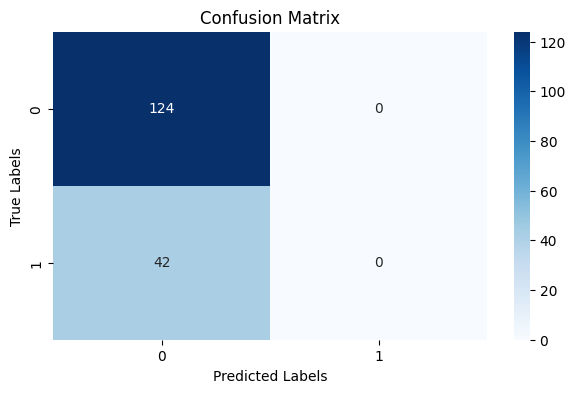

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.3994
Epoch [1/25], Train Loss: 0.6602, Validation Loss: 0.6513, Accuracy: 74.70%


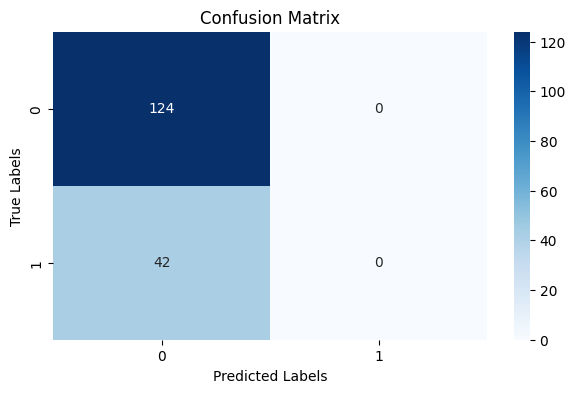

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.5228
Epoch [2/25], Train Loss: 0.6385, Validation Loss: 0.6253, Accuracy: 74.70%


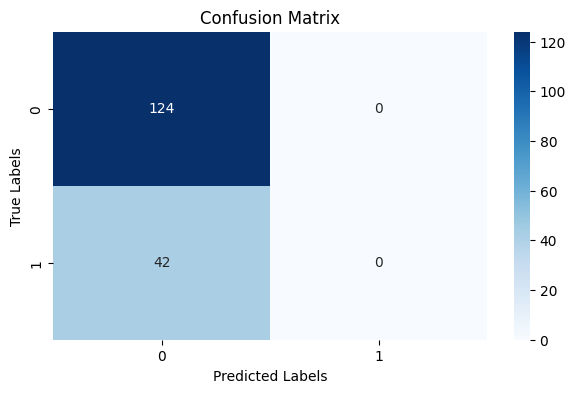

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.5684
Epoch [3/25], Train Loss: 0.6137, Validation Loss: 0.5878, Accuracy: 74.70%


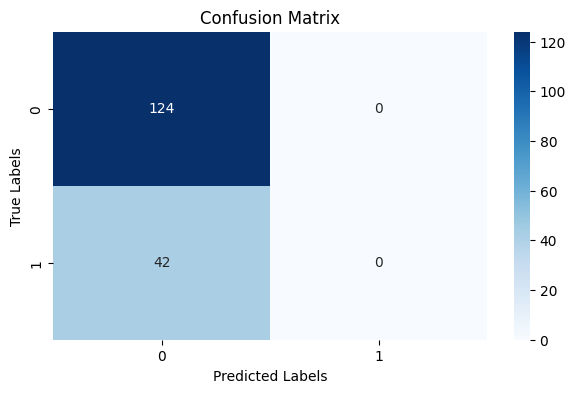

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.4789
Epoch [4/25], Train Loss: 0.5749, Validation Loss: 0.5643, Accuracy: 74.70%


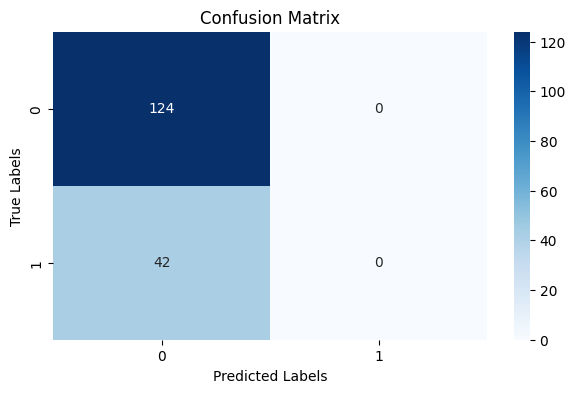

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.5077
Epoch [5/25], Train Loss: 0.5591, Validation Loss: 0.5391, Accuracy: 74.70%


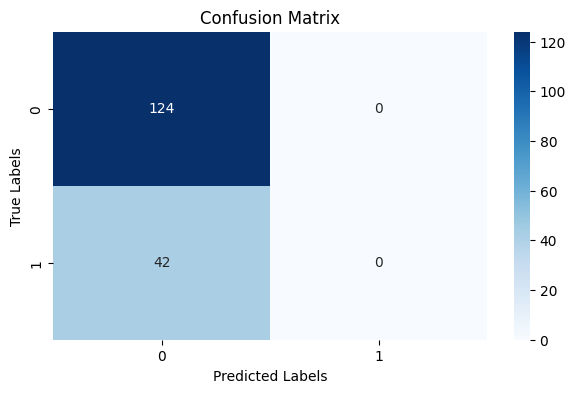

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.5259
Epoch [6/25], Train Loss: 0.5059, Validation Loss: 0.4938, Accuracy: 74.70%


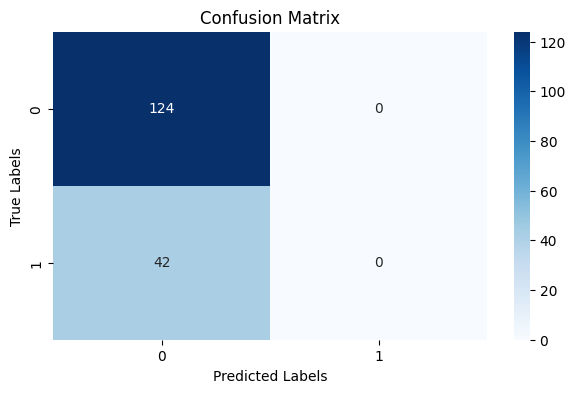

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.4965
Epoch [7/25], Train Loss: 0.4687, Validation Loss: 0.4878, Accuracy: 74.70%


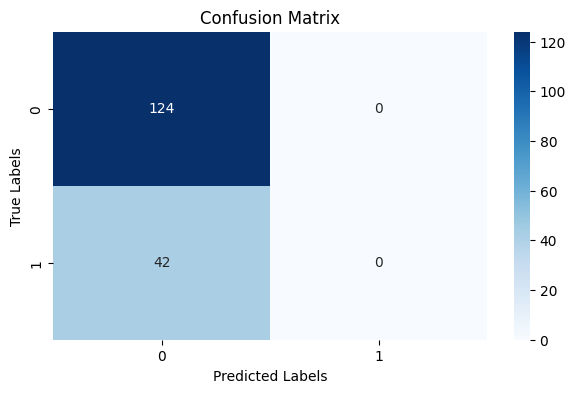

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.5167
Epoch [8/25], Train Loss: 0.4398, Validation Loss: 0.4700, Accuracy: 74.70%


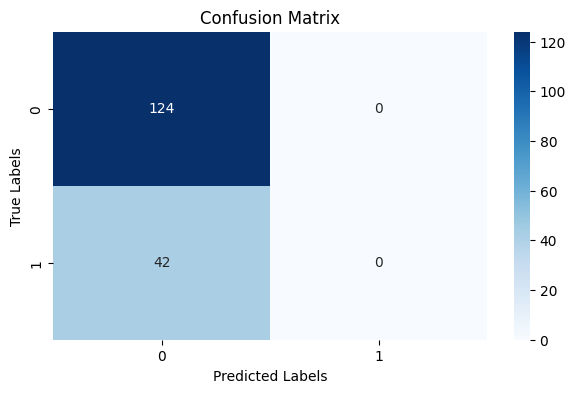

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.5835
Epoch [9/25], Train Loss: 0.3752, Validation Loss: 0.4649, Accuracy: 74.70%


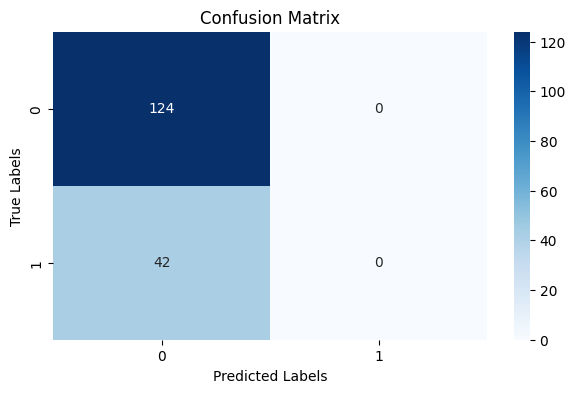

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.4800
Epoch [10/25], Train Loss: 0.3557, Validation Loss: 0.4861, Accuracy: 74.70%


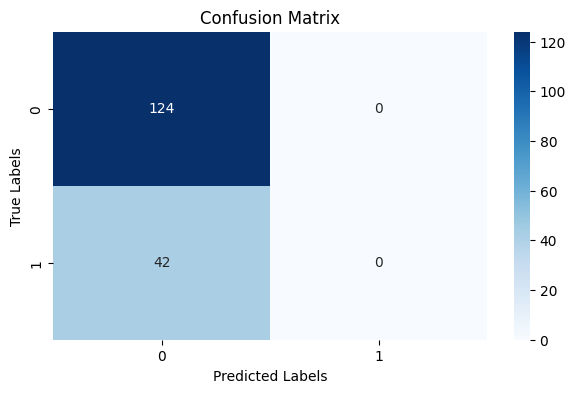

Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/home/chris/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC: 0.5190
Epoch [11/25], Train Loss: 0.3106, Validation Loss: 0.4697, Accuracy: 74.70%


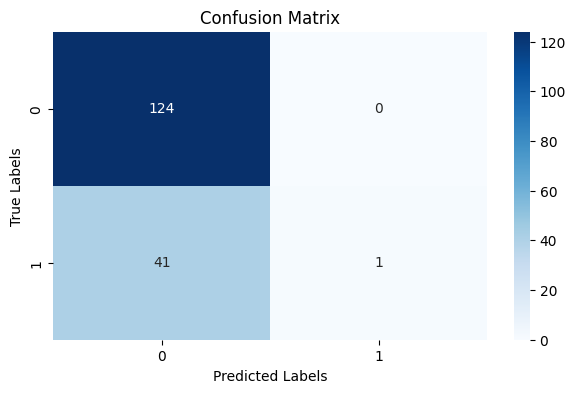

Precision: 1.0000, Recall: 0.0238, F1-Score: 0.0465
AUC-ROC: 0.5152
Epoch [12/25], Train Loss: 0.2992, Validation Loss: 0.4674, Accuracy: 75.30%


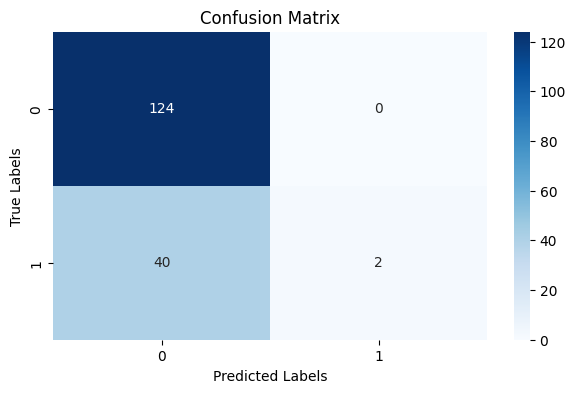

Precision: 1.0000, Recall: 0.0476, F1-Score: 0.0909
AUC-ROC: 0.4697
Epoch [13/25], Train Loss: 0.2630, Validation Loss: 0.4687, Accuracy: 75.90%


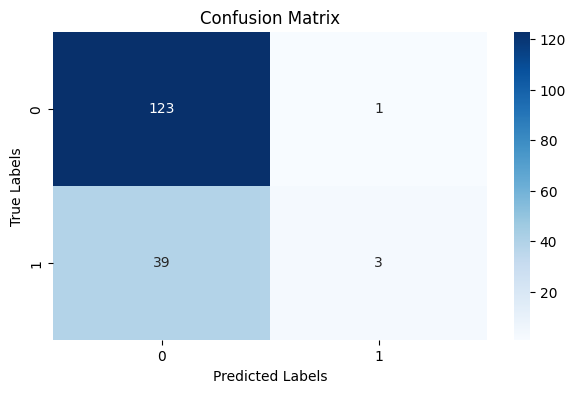

Precision: 0.7500, Recall: 0.0714, F1-Score: 0.1304
AUC-ROC: 0.5156
Epoch [14/25], Train Loss: 0.2990, Validation Loss: 0.4614, Accuracy: 75.90%


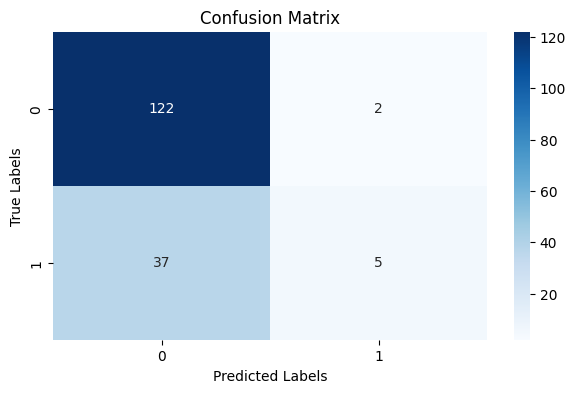

Precision: 0.7143, Recall: 0.1190, F1-Score: 0.2041
AUC-ROC: 0.6006
Epoch [15/25], Train Loss: 0.2351, Validation Loss: 0.4425, Accuracy: 76.51%


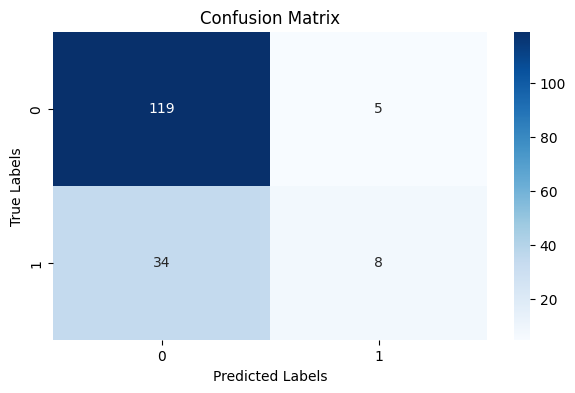

Precision: 0.6154, Recall: 0.1905, F1-Score: 0.2909
AUC-ROC: 0.5561
Epoch [16/25], Train Loss: 0.2230, Validation Loss: 0.4174, Accuracy: 76.51%


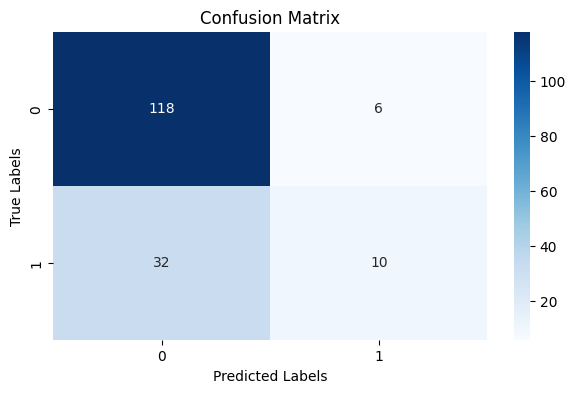

Precision: 0.6250, Recall: 0.2381, F1-Score: 0.3448
AUC-ROC: 0.5119
Epoch [17/25], Train Loss: 0.2173, Validation Loss: 0.4388, Accuracy: 77.11%


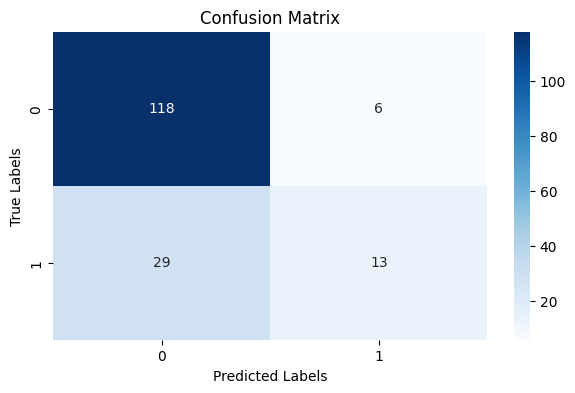

Precision: 0.6842, Recall: 0.3095, F1-Score: 0.4262
AUC-ROC: 0.4954
Epoch [18/25], Train Loss: 0.1902, Validation Loss: 0.4261, Accuracy: 78.92%


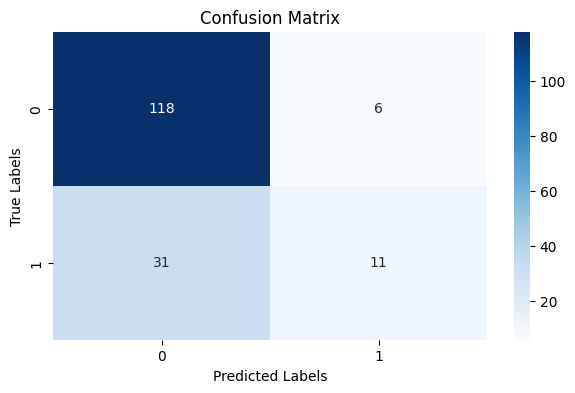

Precision: 0.6471, Recall: 0.2619, F1-Score: 0.3729
AUC-ROC: 0.4574
Epoch [19/25], Train Loss: 0.1841, Validation Loss: 0.4428, Accuracy: 77.71%


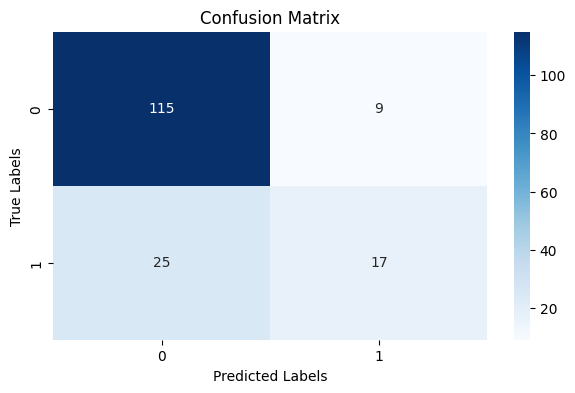

Precision: 0.6538, Recall: 0.4048, F1-Score: 0.5000
AUC-ROC: 0.5505
Epoch [20/25], Train Loss: 0.1654, Validation Loss: 0.4026, Accuracy: 79.52%


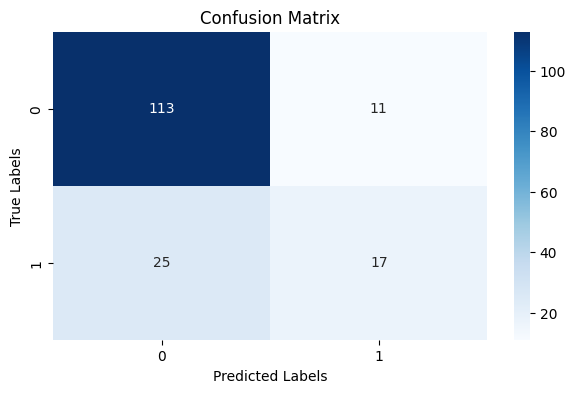

Precision: 0.6071, Recall: 0.4048, F1-Score: 0.4857
AUC-ROC: 0.4520
Epoch [21/25], Train Loss: 0.1468, Validation Loss: 0.4327, Accuracy: 78.31%


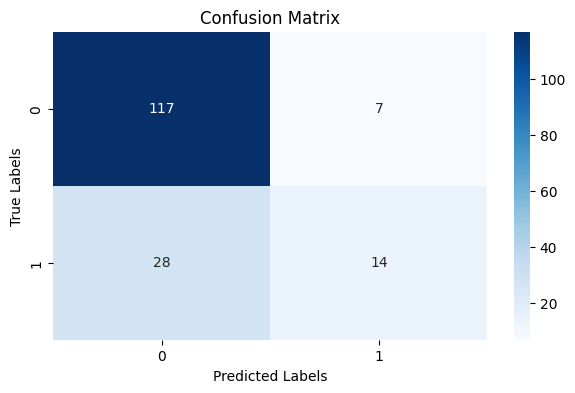

Precision: 0.6667, Recall: 0.3333, F1-Score: 0.4444
AUC-ROC: 0.4441
Epoch [22/25], Train Loss: 0.1582, Validation Loss: 0.4468, Accuracy: 78.92%


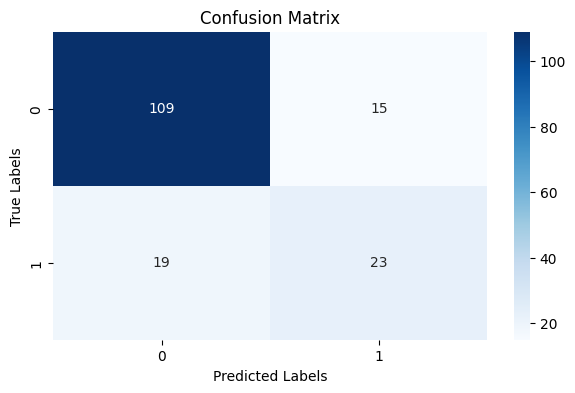

Precision: 0.6053, Recall: 0.5476, F1-Score: 0.5750
AUC-ROC: 0.4435
Epoch [23/25], Train Loss: 0.1221, Validation Loss: 0.4015, Accuracy: 79.52%


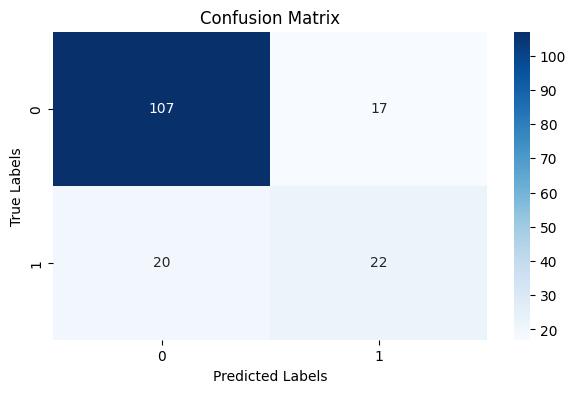

Precision: 0.5641, Recall: 0.5238, F1-Score: 0.5432
AUC-ROC: 0.5257
Epoch [24/25], Train Loss: 0.1115, Validation Loss: 0.4279, Accuracy: 77.71%


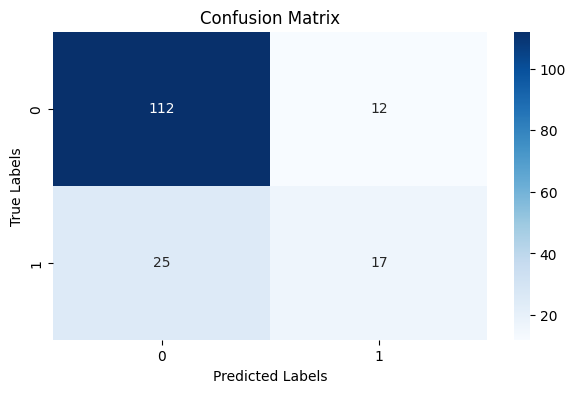

Precision: 0.5862, Recall: 0.4048, F1-Score: 0.4789
AUC-ROC: 0.5532
Epoch [25/25], Train Loss: 0.1070, Validation Loss: 0.4343, Accuracy: 77.71%


In [8]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.00001, weight_decay=1e-3)
num_epochs = 25
for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0
    for images, labels in train_loader:
        #print('iter')
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculando la pérdida promedio en la época
    train_loss /= len(train_loader)

    resnet.eval()
    validation_loss = 0
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # Obtén las predicciones binarias
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Guarda las predicciones y etiquetas para la matriz de confusión
            # Importante: aplana los arrays para que sean 1D
            all_predicted.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    validation_loss /= len(test_loader)
    accuracy = 100 * correct / total
    
    # Convierte a arrays numpy para la matriz de confusión
    all_predicted = np.array(all_predicted)
    all_labels = np.array(all_labels)
    
    # Calculando la matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(7,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='binary')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    
    # Si quieres calcular el AUC-ROC (necesitas las probabilidades, no las etiquetas binarias)
    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = resnet(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
    
    auc_roc = roc_auc_score(all_labels, all_probs)
    print(f'AUC-ROC: {auc_roc:.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [ ]:
print((predicted == labels))